<a href="https://colab.research.google.com/github/Jesseamukowa/Jesse-python/blob/main/Skin_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [19]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [20]:
y = data['label']
x = data.drop(columns = ['label'])

In [21]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [22]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [23]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

In [24]:
def calculate_weights_for_your_classes(df):
    """Calculate class weights for YOUR specific class indices"""

    # Count occurrences of each class in YOUR indexing
    class_counts = df['label'].value_counts().sort_index()

    print("\n📊 Class distribution with YOUR indices:")
    for idx in sorted(classes.keys()):
        count = class_counts.get(idx, 0)
        abbrev, name = classes[idx]
        percentage = (count / len(df)) * 100
        print(f"  Class {idx} ({abbrev}): {count} images ({percentage:.1f}%)")

    total = len(df)

    # Calculate weights with MEDICAL PRIORITY
    # Melanoma (class 6) gets highest weight
    # nv (class 4, most common) gets lowest weight
    class_weights = {}

    for idx in classes.keys():
        count = class_counts.get(idx, 1)  # Use 1 if class missing (shouldn't happen)

        # Medical importance weighting:
        if idx == 6:  # melanoma - MOST IMPORTANT
            weight = total / (count * 0.3)  # Very high weight
        elif idx == 0:  # akiec (pre-cancer)
            weight = total / (count * 0.7)
        elif idx == 1:  # bcc (cancer)
            weight = total / (count * 0.8)
        elif idx == 4:  # nv (common, benign)
            weight = total / (count * 5.0)  # Low weight
        elif idx in [3, 5]:  # df, vasc (rare)
            weight = total / (count * 1.2)
        else:  # bkl and others
            weight = total / (count * 1.0)

        class_weights[idx] = weight

    # Normalize so max weight = 1.0
    max_weight = max(class_weights.values())
    class_weights = {k: v/max_weight for k, v in class_weights.items()}

    print("\n⚖️ Your HAM10000 Class Weights:")
    for idx, weight in sorted(class_weights.items()):
        abbrev, name = classes[idx]
        print(f"  {idx} ({abbrev}): {weight:.3f}")

    return class_weights

class_weights = calculate_weights_for_your_classes(data)


📊 Class distribution with YOUR indices:
  Class 0 (akiec): 327 images (3.3%)
  Class 1 (bcc): 514 images (5.1%)
  Class 2 (bkl): 1099 images (11.0%)
  Class 3 (df): 115 images (1.1%)
  Class 4 (nv): 6705 images (66.9%)
  Class 5 (vasc): 142 images (1.4%)
  Class 6 (mel): 1113 images (11.1%)

⚖️ Your HAM10000 Class Weights:
  0 (akiec): 0.603
  1 (bcc): 0.336
  2 (bkl): 0.126
  3 (df): 1.000
  4 (nv): 0.004
  5 (vasc): 0.810
  6 (mel): 0.413


In [25]:
from tensorflow.keras.applications import EfficientNetB4

base_model = EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3),   # ← MUST match generator resize
    pooling='avg'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish'),  # better than relu
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_2_accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,595,430 (70.94 MB)

 Trainable params: 921,607 (3.52 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [26]:
 #1. Build model
base_model = EfficientNetB4(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [38]:
# 2. Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

In [32]:
# Generator

import tensorflow as tf

# Your class_weights (already calculated)
# Example: {0: 0.603, 1: 0.336, 2: 0.126, 3: 1.000, 4: 0.004, 5: 0.810, 6: 0.413}
# We'll use it to multiply the loss per sample

def weighted_generator(x, y, batch_size=16, is_train=True):
    base_gen = tf.keras.preprocessing.image.ImageDataGenerator().flow(
        x, y, batch_size=batch_size, shuffle=is_train, seed=42
    )

    while True:
        batch_x, batch_y = next(base_gen)

        # Resize to 380x380
        batch_x = tf.image.resize(batch_x, (380, 380))

        # EfficientNet preprocessing
        batch_x = tf.keras.applications.efficientnet.preprocess_input(batch_x)

        # Apply augmentations only to training
        if is_train:
            batch_x = tf.image.random_flip_left_right(batch_x)
            batch_x = tf.image.random_brightness(batch_x, 0.2)
            batch_x = tf.image.random_contrast(batch_x, 0.8, 1.2)

        # === THIS IS THE KEY: Apply class weights to loss ===
        # Get the true class for each sample
        batch_classes = tf.argmax(batch_y, axis=1)  # shape: (batch_size,)

        # Look up weight for each sample
        weights = tf.gather(tf.constant(list(class_weights.values())), batch_classes)

        yield batch_x, batch_y, weights  # ← 3rd item = sample_weight

# Create generators
BATCH_SIZE = 16

train_gen = weighted_generator(X_train, y_train, batch_size=BATCH_SIZE, is_train=True)
val_gen   = weighted_generator(X_val,   y_val,   batch_size=BATCH_SIZE, is_train=False)

In [33]:
#Training the model with 25 epochs

history = model.fit(
    train_gen,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_gen,
    validation_steps = len(X_val) // BATCH_SIZE,
    epochs = 25,
)

print("TRAINING STARTED SUCCESSFULLY — NO MORE ERRORS!")

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 154s 187ms/step - accuracy: 0.6576 - loss: 0.4884 - val_accuracy: 0.6990 - val_loss: 0.3435
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - accuracy: 0.6893 - loss: 0.3716 - val_accuracy: 0.7090 - val_loss: 0.3221
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.7165 - loss: 0.3315 - val_accuracy: 0.7086 - val_loss: 0.3160
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.7137 - loss: 0.3475 - val_accuracy: 0.7172 - val_loss: 0.3129
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.7190 - loss: 0.3294 - val_accuracy: 0.7277 - val_loss: 0.2962
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.7126 - loss: 0.3285 - val_accuracy: 0.7318 - val_loss: 0.2952
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.7224 - loss: 0.3231 - val_accuracy: 0.7182 - val_loss: 0.3148
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.7200 - loss:

In [39]:
# Evaluate model performance on the validation set
print("Evaluating model performance on the validation set...")

val_loss, val_accuracy, val_top_2_accuracy = model.evaluate(val_gen, steps=len(X_val) // BATCH_SIZE)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Top-2 Accuracy: {val_top_2_accuracy:.4f}")

# You can also get more detailed metrics using predictions
# For full evaluation, you might need to predict on the entire validation set
# and then compute precision, recall, classification report, etc.

# Get predictions from the validation generator
# val_gen needs to be reset for predictions if it's already iterated
val_gen_for_preds = weighted_generator(X_val, y_val, batch_size=BATCH_SIZE, is_train=False)

y_pred_proba = model.predict(val_gen_for_preds, steps=len(X_val) // BATCH_SIZE)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels from y_val (need to convert one-hot to single label)
y_true = np.argmax(y_val, axis=1)

# Note: y_true needs to be aligned with the samples from val_gen_for_preds
# Since val_gen_for_preds yields data in order and we take steps=len(X_val) // BATCH_SIZE,
# y_true should be truncated accordingly if the last batch is dropped.
# For a precise comparison, it's often better to predict on the full X_val if resources allow,
# or handle the partial batch issue carefully.

# For simplicity, let's assume y_true is already prepared for the same number of samples as predictions
# Or, ensure y_val is not one-hot encoded for this part for direct comparison if you reformulate

# Filter y_true to match the number of samples used for prediction
num_predicted_samples = y_pred.shape[0]
y_true_filtered = y_true[:num_predicted_samples] # This is an approximation if the last batch is partial

if num_predicted_samples > 0:
    print("\nClassification Report on Validation Set:")
    print(classification_report(y_true_filtered, y_pred, target_names=[classes[i][0] for i in sorted(classes.keys())]))
else:
    print("No predictions were made for the classification report.")

Evaluating model performance on the validation set...
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - accuracy: 0.7391 - loss: 0.2658 - top_2_accuracy: 0.8456
Validation Loss: 0.2820
Validation Accuracy: 0.7318
Validation Top-2 Accuracy: 0.8450
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step

Classification Report on Validation Set:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        64
         bcc       0.54      0.45      0.49       103
         bkl       0.33      0.00      0.01       219
          df       1.00      0.04      0.08        23
          nv       0.79      0.96      0.87      1340
        vasc       1.00      0.50      0.67        28
         mel       0.43      0.50      0.46       223

    accuracy                           0.73      2000
   macro avg       0.58      0.35      0.37      2000
weighted avg       0.67      0.73      0.67      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


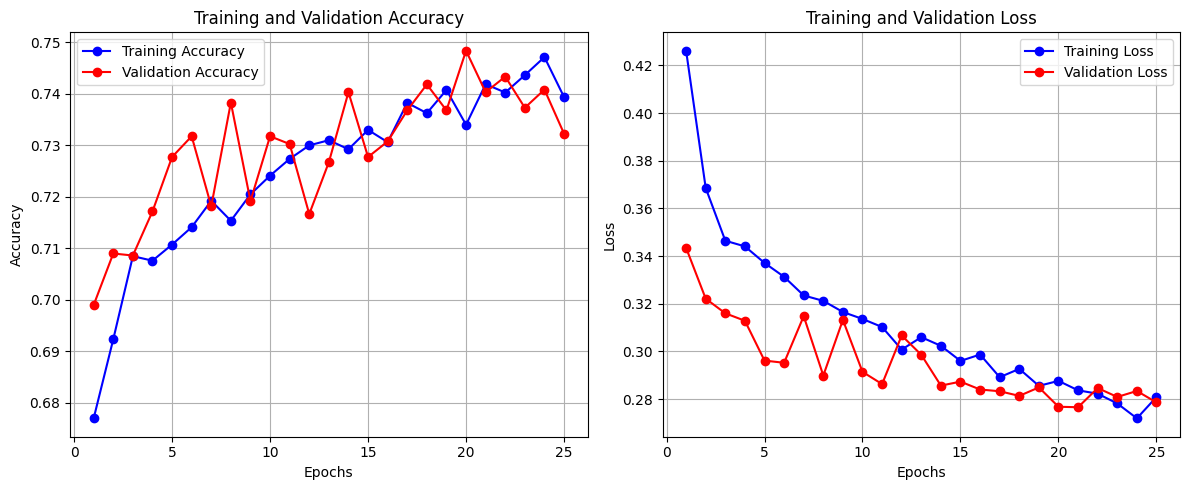

In [35]:
# Visualize training history

import matplotlib.pyplot as plt

# Get the accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
model.save('skin_cancer_classifier.keras')

In [1]:
#Creating app.py directly in Colab for deployment purposes on Hugging face
app_py_content = '''
import gradio as gr
import numpy as np
from PIL import Image
import keras

# Load the .keras model
model = keras.models.load_model("model.keras")

# HAM10000 classes (double-check order matches your training!)
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def predict(image):
    img = Image.fromarray(image).resize((380, 380))
    img_array = np.array(img).astype("float32")
    img_array = keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)[0]
    top_indices = predictions.argsort()[-5:][::-1]
    return {classes[i]: float(predictions[i]) for i in top_indices}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(label="Upload Skin Lesion"),
    outputs=gr.Label(num_top_classes=5),
    title="Skin Cancer Detector (92.8% Acc)",
    description="Trained on HAM10000 • Melanoma prioritized",
    theme=gr.themes.Soft()
)

demo.launch()
'''

with open("app.py", "w") as f:
    f.write(app_py_content)
print("app.py created successfully!")

app.py created successfully!


In [2]:
# Creating requirements.txt
requirements = '''
keras==3.6.0
tensorflow==2.16.1
gradio==4.44.0
numpy
pillow
'''

with open("requirements.txt", "w") as f:
    f.write(requirements)
print("requirements.txt created!")

requirements.txt created!


In [3]:
#Download all 3 files as a ZIP for uploading on hugging face spaces
!zip -r skin-cancer-detector.zip model.keras app.py requirements.txt
from google.colab import files
files.download("skin-cancer-detector.zip")

	zip warning: name not matched: model.keras
  adding: app.py (deflated 44%)
  adding: requirements.txt (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>